In [10]:
from sotip import *
import numpy as np
import scanpy as sc


In [11]:
adata = sc.read_h5ad('spagcn_result/MIBI_p9_scagcn_20211201.h5ad')

In [5]:
adata.var_names

Index(['Beta catenin', 'CD11b', 'CD11c', 'CD138', 'CD16', 'CD20', 'CD209',
       'CD3', 'CD31', 'CD4', 'CD45', 'CD45RO', 'CD56', 'CD63', 'CD68', 'CD8',
       'dsDNA', 'EGFR', 'FoxP3', 'H3K27Me3', 'H3K9ac', 'HLA-DR', 'HLA_Class_1',
       'IDO', 'Keratin17', 'Keratin6', 'Ki67', 'Lag3', 'MPO', 'p53',
       'Pan-Keratin', 'PD-L1', 'PD1', 'phospho-S6', 'SMA', 'Vimentin'],
      dtype='object')

In [12]:
me_array = np.array(adata[:,'H3K27Me3'].X)
ac_array = np.array(adata[:,'H3K9ac'].X)
adata_add = ad.AnnData((me_array+1)/(ac_array+1))
adata_add.var_names = ['Me/Ac']
adata_add.obs_names = adata.obs_names
adata = ad.concat([adata,adata_add],axis=1,merge='first')

In [4]:
adata.uns['leiden_EMD_merge_colors'] = ['r','k']

In [17]:
rename_dict = {
    1:'immune',
    0:'tumor'
}
adata.obs['pred'] = adata.obs['pred'].cat.rename_categories(rename_dict)

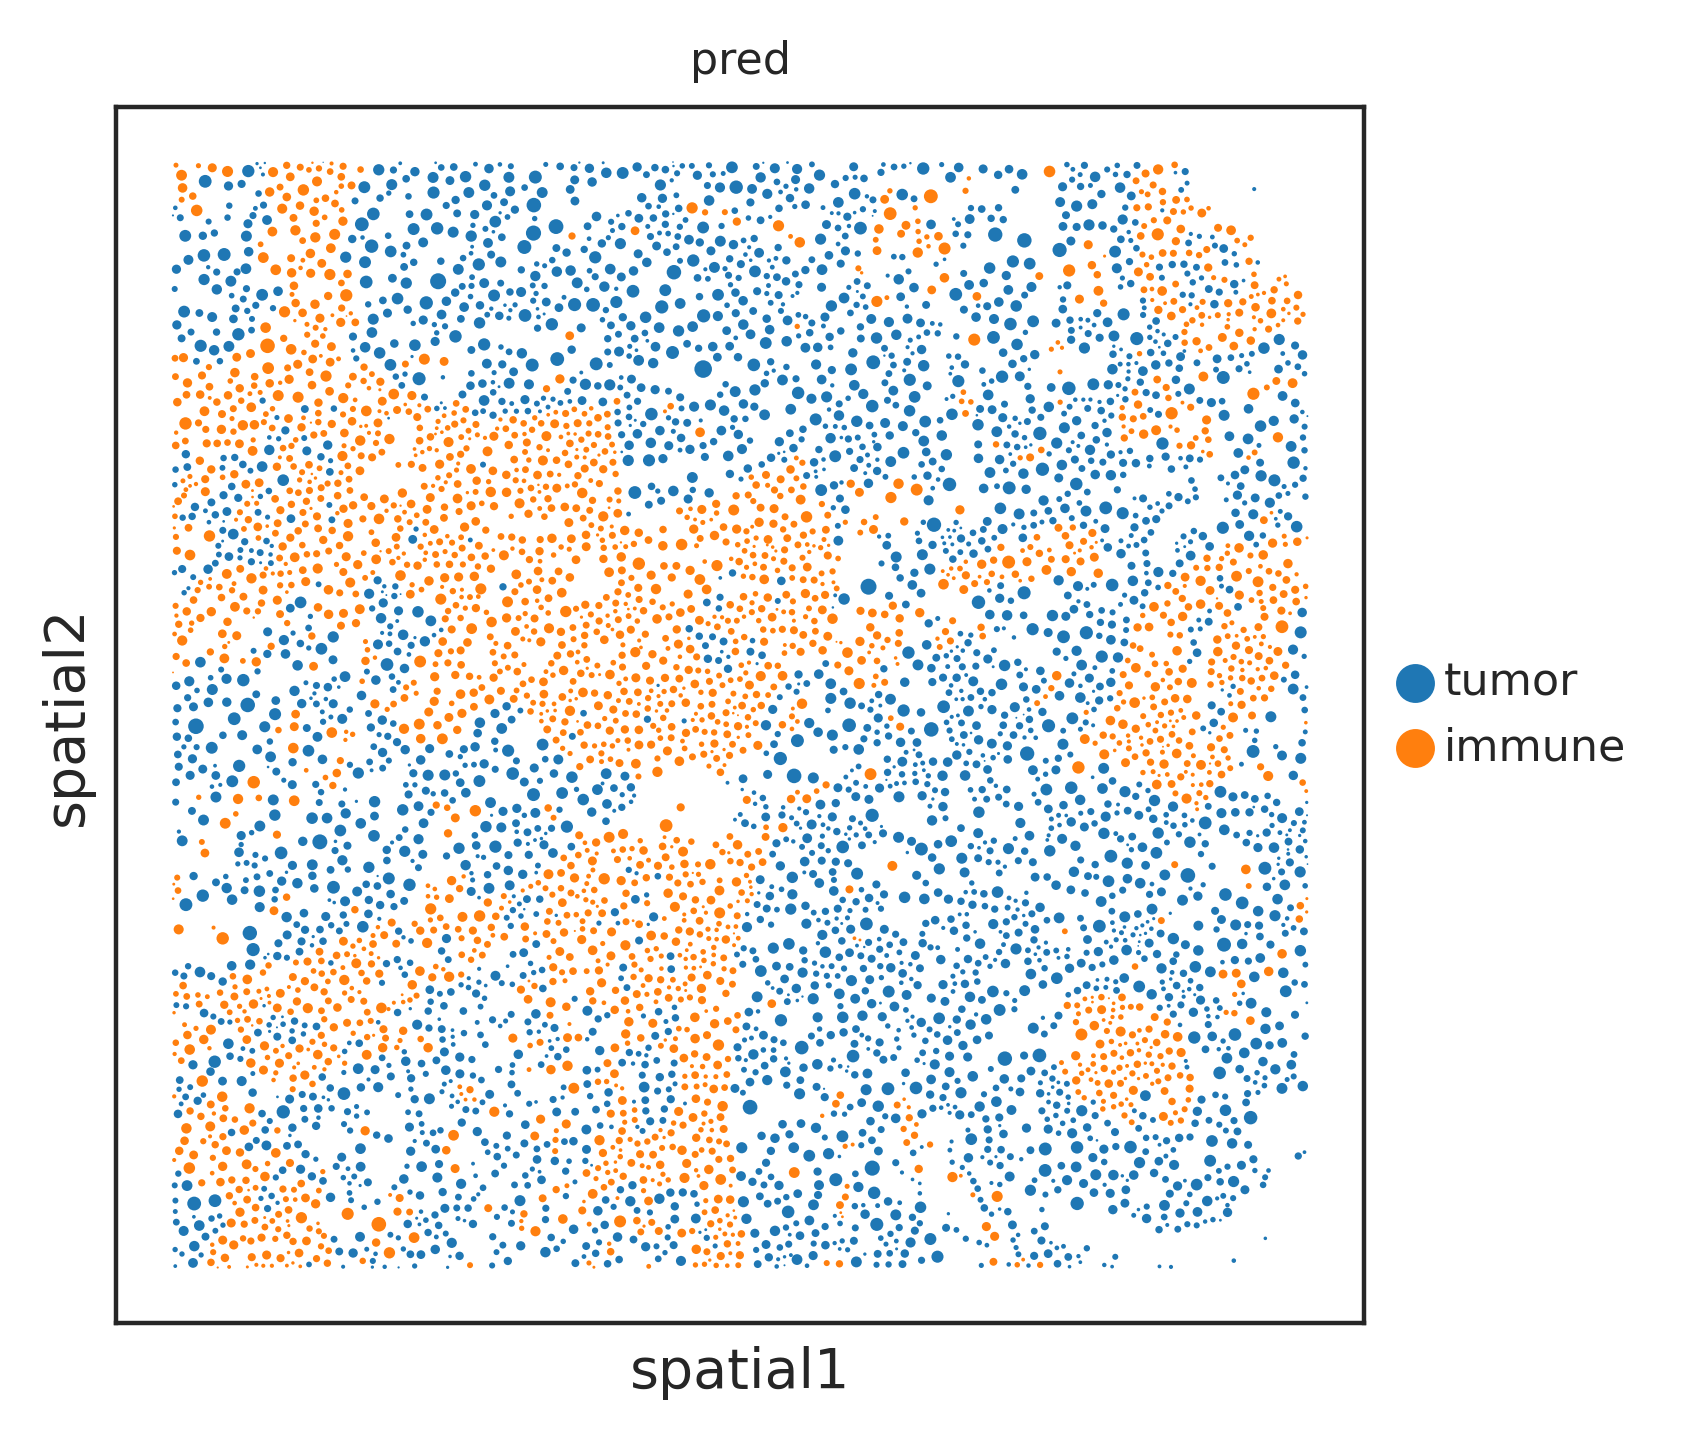

In [18]:
sc.pl.embedding(adata,basis='spatial',color=['pred'],size=adata.obs['cell_size']/50)

In [19]:
# 分别计算所有细胞到这两类区域的最短距离
spatial_mat = adata.obsm['spatial']
dist_mat = squareform(pdist(spatial_mat))

In [21]:
for region in adata.obs['pred'].cat.categories:
    cur_idx = np.where(adata.obs['pred']==region)[0]
    cur_dist_obs = f'min_dist_to_{region}'
    cur_min_dist = np.min(dist_mat[:,cur_idx],axis=1)
    adata.obs[cur_dist_obs] = cur_min_dist

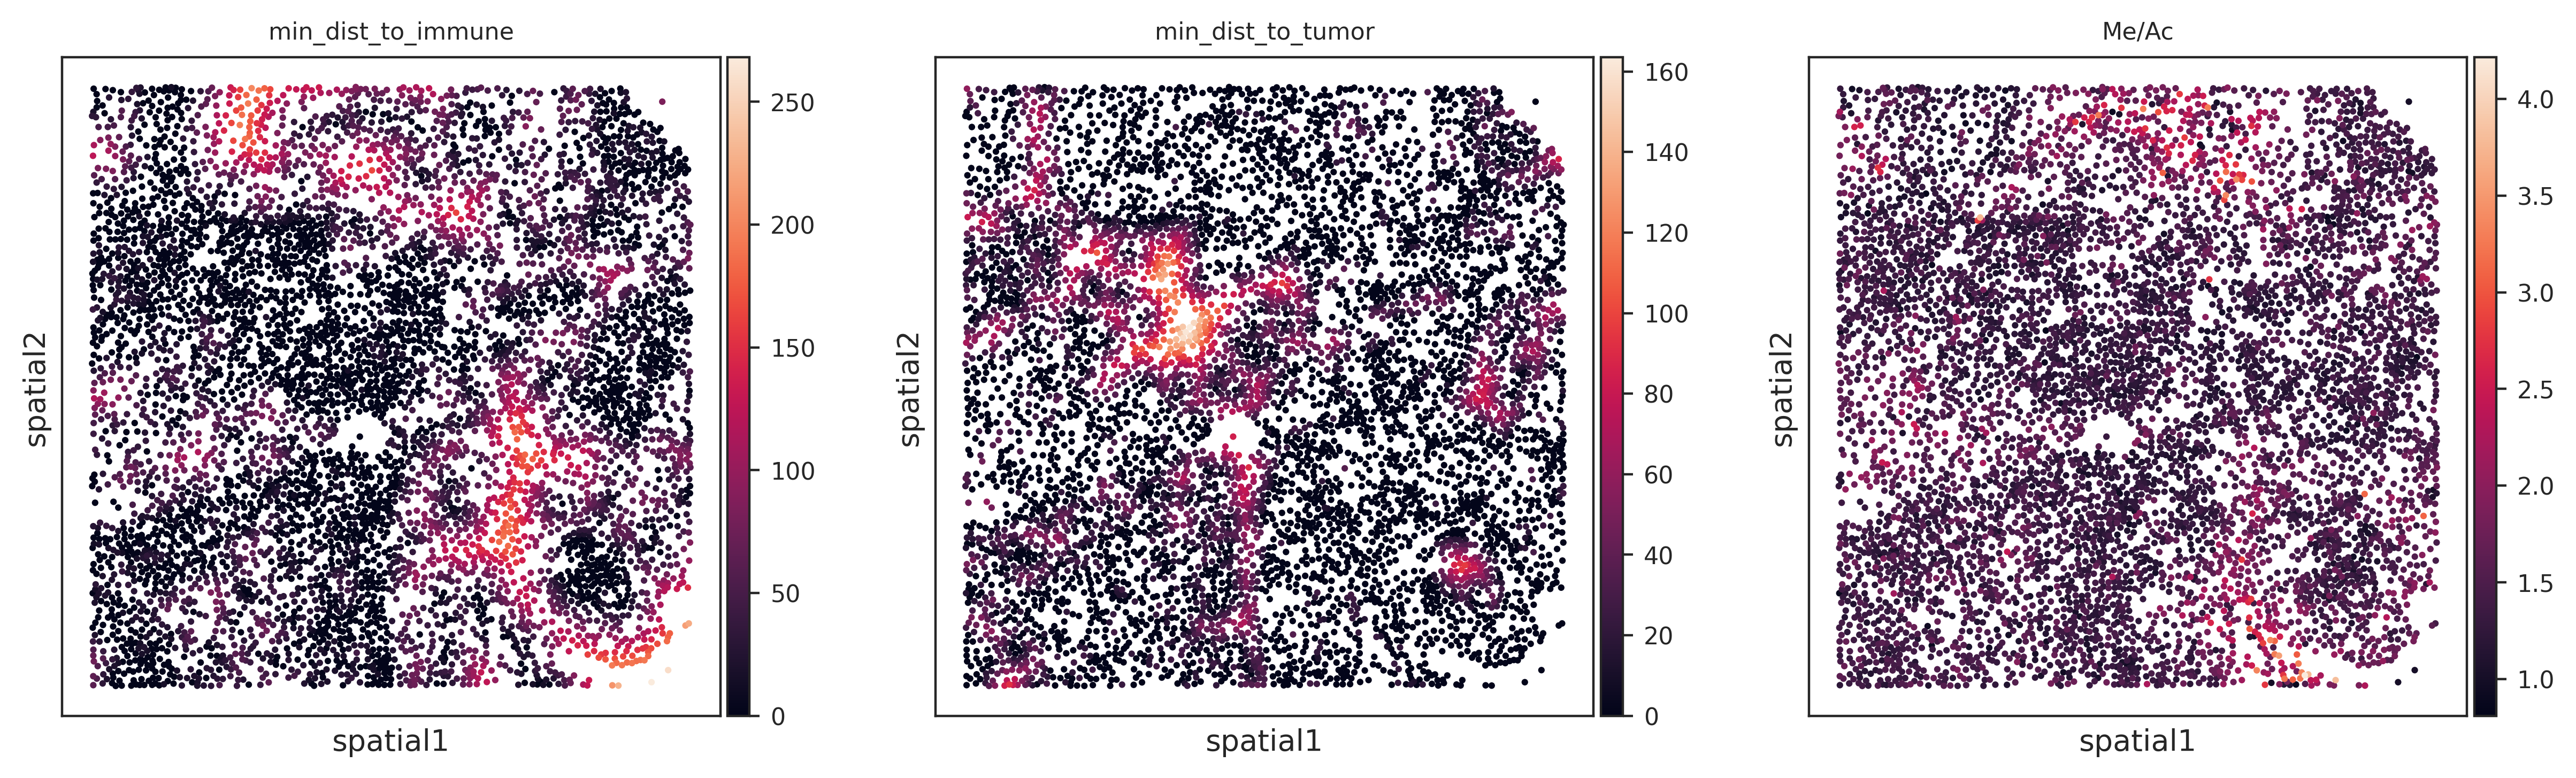

In [22]:
sc.pl.embedding(adata,basis='spatial',color=['min_dist_to_immune','min_dist_to_tumor','Me/Ac'])

# polarize in tumor

In [23]:

# from original paper
boundary_sz_pixel = 100

In [24]:
boundary_array = np.array(adata.obs['pred'].copy())
min_dist_to_immune_array = np.array(adata.obs['min_dist_to_immune'].copy())
min_dist_to_tumor_array = np.array(adata.obs['min_dist_to_tumor'].copy())

In [25]:
boundary_array[(boundary_array=='tumor') & (min_dist_to_immune_array<=boundary_sz_pixel)] = 'boundary_tumor'
boundary_array[(boundary_array=='immune') & (min_dist_to_tumor_array<=boundary_sz_pixel)] = 'boundary_immune'

In [26]:
adata.obs['boundary'] = boundary_array

/root/anaconda3/envs/SOTIP/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'boundary' as categorical


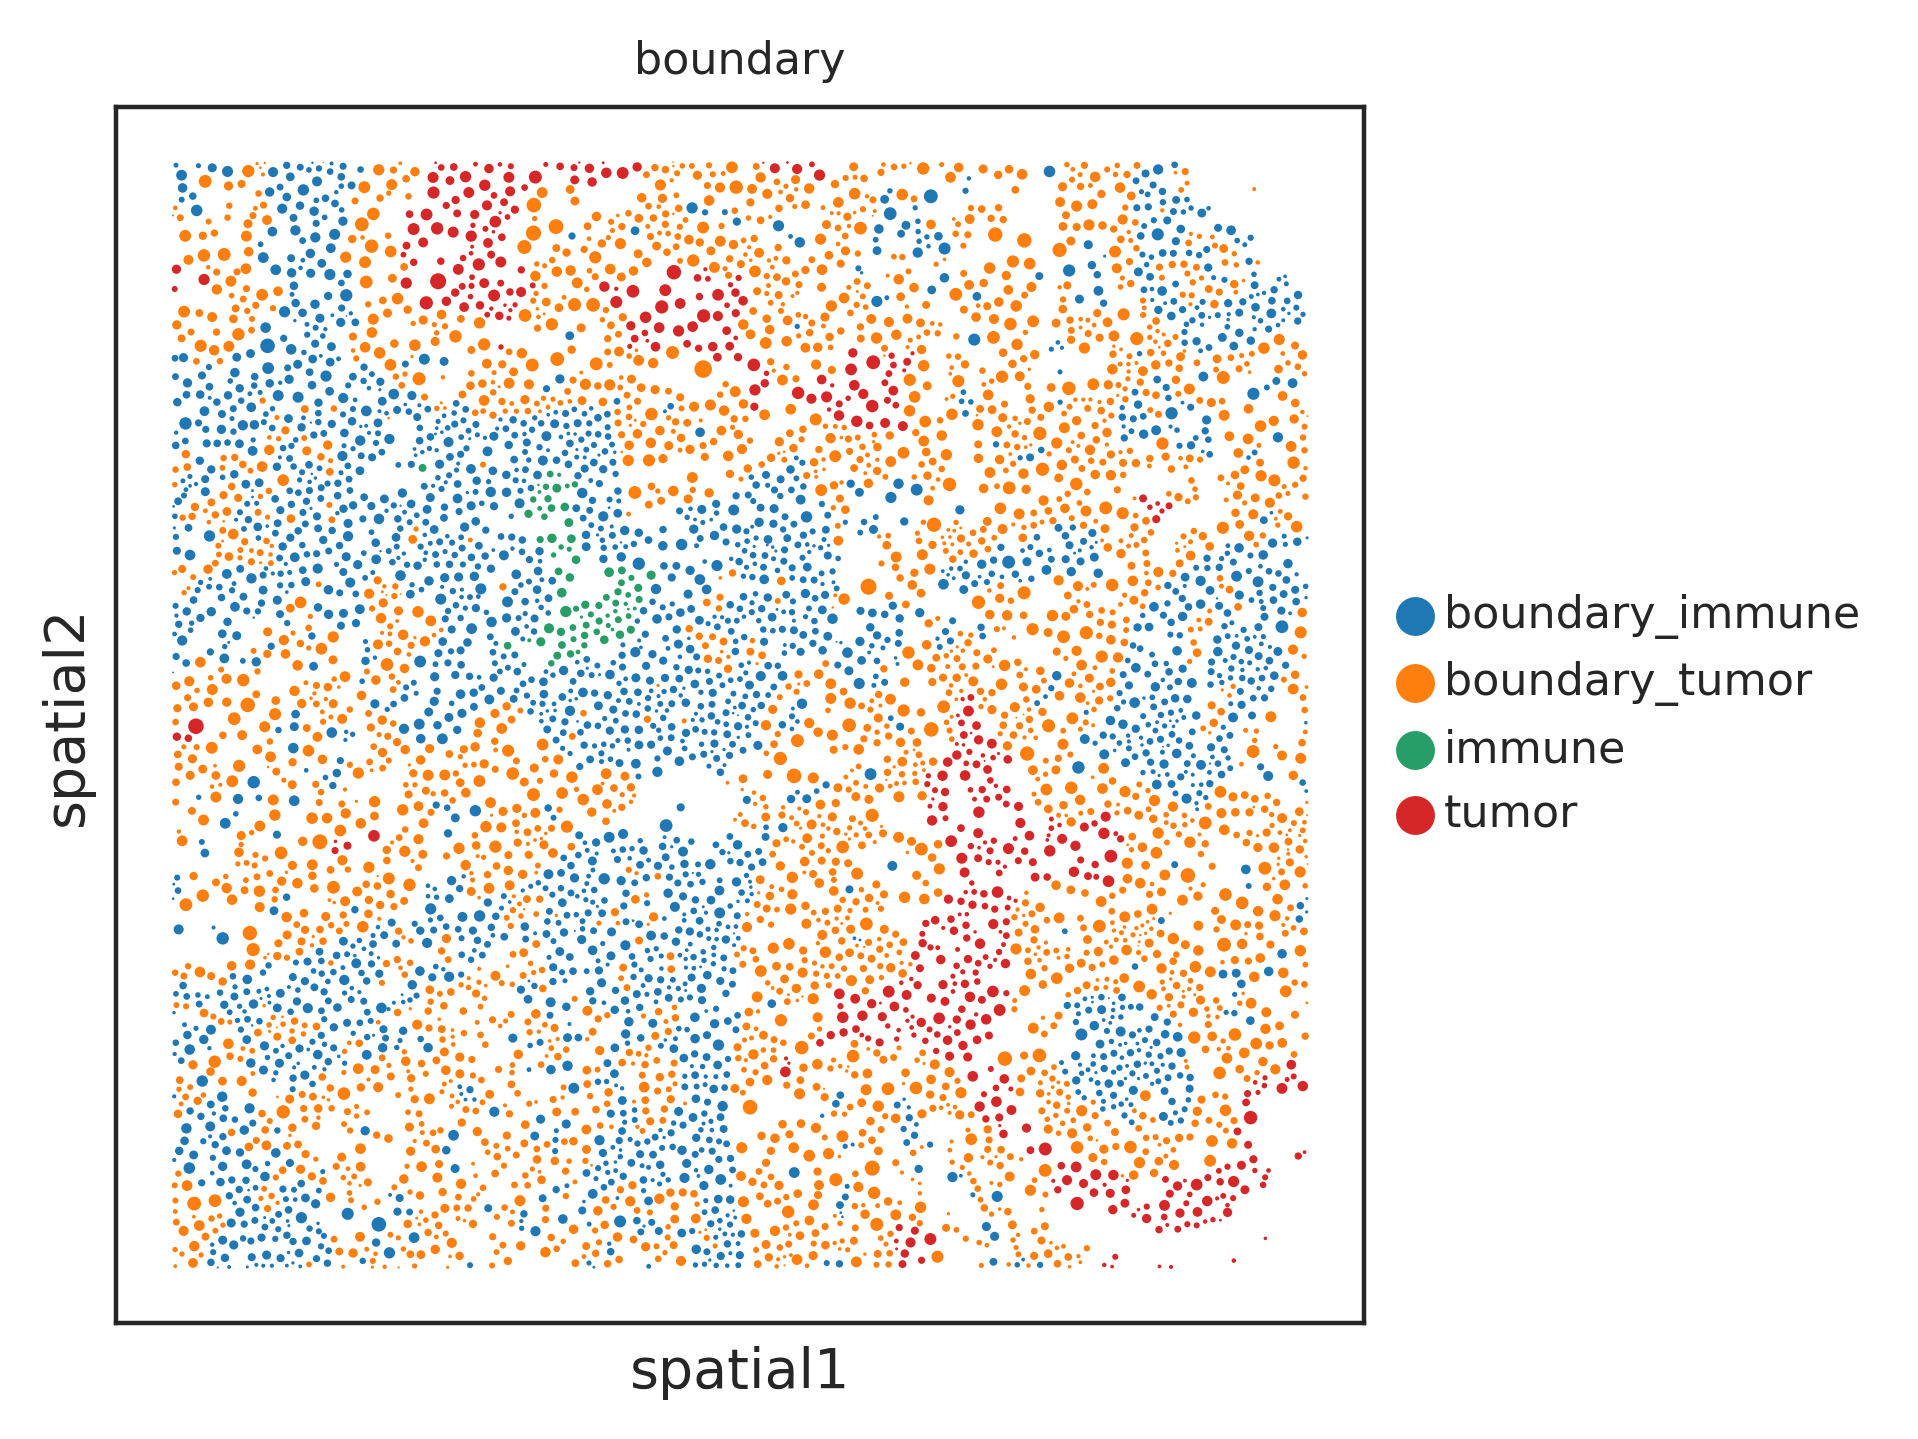

In [27]:
sc.pl.embedding(adata,basis='spatial',color=['boundary'],size=adata.obs['cell_size']/50)

In [28]:

def test_polar(adata,obs,between,protein,var):
    array_0 = np.array(adata[adata.obs[obs]==between[0],protein].X)
    array_1 = np.array(adata[adata.obs[obs]==between[1],protein].X)
    pv = ranksums(array_0,array_1,alternative='two-sided')[1]
    adata.var[var][np.where(adata.var_names==protein)[0]] = pv
    
    
    
    return pv

# porlar to tumor, ranksum

In [29]:
from pingouin import multicomp
obs = 'boundary'
between = ['boundary_tumor','tumor']
var_name = 'spagcn_polar_in_tumor'
adata.var[var_name] = np.zeros(shape=(adata.shape[1]))
for protein in adata.var_names:
    test_polar(adata,obs,between,protein,var_name)
pv_list = np.array(adata.var[var_name])
_,pv_adj = multicomp(pv_list,method='fdr_bh')
adata.var[f'{var_name}_bh'] = pv_adj

In [30]:
from pingouin import multicomp
obs = 'boundary'
between = ['boundary_immune','immune']
var_name = 'spagcn_polar_in_immune'
adata.var[var_name] = np.zeros(shape=(adata.shape[1]))
for protein in adata.var_names:
    test_polar(adata,obs,between,protein,var_name)
pv_list = np.array(adata.var[var_name])
_,pv_adj = multicomp(pv_list,method='fdr_bh')
adata.var[f'{var_name}_bh'] = pv_adj

In [31]:
adata.var

spagcn_polar_in_tumor  spagcn_polar_in_tumor_bh  \
Beta catenin           8.348626e-04              1.930620e-03   
CD11b                  1.072762e-04              3.053247e-04   
CD11c                  1.817335e-06              7.471265e-06   
CD138                  3.945620e-01              5.839518e-01   
CD16                   9.532442e-16              7.054007e-15   
CD20                   1.207729e-01              1.942869e-01   
CD209                  7.692460e-04              1.897473e-03   
CD3                    2.310735e-06              8.549721e-06   
CD31                   3.313287e-02              6.129582e-02   
CD4                    7.506840e-03              1.633842e-02   
CD45                   1.807116e-38              6.686329e-37   
CD45RO                 2.193509e-22              2.705328e-21   
CD56                   9.907618e-01              9.907618e-01   
CD63                   2.853794e-01              4.399599e-01   
CD68                   8.734185e-13              4.616640e-12   
CD8                    9.715294e-03              1.997033e-02   
dsDNA                  1.617855e-04              4.275760e-04   
EGFR                   7.386585e-02              1.242289e-01   
FoxP3                  8.803526e-01              9.435678e-01   
H3K27Me3               1.165444e-02              2.269548e-02   
H3K9ac                 8.396810e-05              2.589016e-04   
HLA-DR                 6.772871e-01              8.301769e-01   
HLA_Class_1            6.771312e-01              8.301769e-01   
IDO                    6.094511e-01              8.053461e-01   
Keratin17              6.955536e-01              8.301769e-01   
Keratin6               1.591947e-21              1.472551e-20   
Ki67                   8.925641e-01              9.435678e-01   
Lag3                   8.775514e-01              9.435678e-01   
MPO                    5.692042e-01              7.800206e-01   
p53                    9.887782e-01              9.907618e-01   
Pan-Keratin            1.721131e-15              1.061364e-14   
PD-L1                  5.596551e-02              9.860591e-02   
PD1                    7.605293e-01              8.793620e-01   
phospho-S6             1.372458e-26              2.539047e-25   
SMA                    4.800035e-01              6.830819e-01   
Vimentin               3.482558e-07              1.610683e-06   
Me/Ac                  4.163352e-05              1.400400e-04   

              spagcn_polar_in_immune  spagcn_polar_in_immune_bh  
Beta catenin            5.020530e-04               1.547997e-03  
CD11b                   9.671397e-05               4.473021e-04  
CD11c                   5.386946e-07               3.488657e-06  
CD138                   8.139107e-01               8.857263e-01  
CD16                    1.673037e-03               4.761719e-03  
CD20                    4.650256e-03               1.147063e-02  
CD209                   1.309708e-07               1.211480e-06  
CD3                     2.876786e-04               1.064411e-03  
CD31                    5.811277e-01               7.963602e-01  
CD4                     7.629080e-09               9.409198e-08  
CD45                    5.657282e-07               3.488657e-06  
CD45RO                  1.060003e-05               5.602871e-05  
CD56                    8.850349e-01               9.356083e-01  
CD63                    3.662967e-03               9.680699e-03  
CD68                    1.161783e-02               2.451595e-02  
CD8                     3.768364e-04               1.267541e-03  
dsDNA                   7.039062e-01               8.535909e-01  
EGFR                    7.857539e-01               8.857263e-01  
FoxP3                   4.764065e-01               6.779631e-01  
H3K27Me3                3.592478e-02               6.329603e-02  
H3K9ac                  2.359383e-02               4.364858e-02  
HLA-DR                  1.203068e-01               2.023342e-01  
HLA_Class_1             1

In [24]:
gt_polarized_tumor_all = ['EGFR','Beta catenin','Pan-Keratin','p53','Ki67','Me/Ac','Keratin6','Keratin17','PD-L1','HLA-DR']
gt_polarized_immune_all = ['CD20','CD209','CD11b','HLA-DR','FoxP3','Ki67','CD56','MPO','Lag3','PD-L1','IDO','CD45RO','PD1','CD8','CD3','CD4','CD11c','CD16','CD68']



In [32]:
# gt_polarized_tumor_p4 = ['EGFR','Beta catenin','Me/Ac','Keratin6','Keratin17','PD-L1','HLA-DR']
# gt_polarized_immune_p4 = ['CD20','CD209','HLA-DR','FoxP3','PD-L1','IDO','CD45RO','CD4','CD11c','CD68']
gt_polarized_tumor_p9 = ['Me/Ac','PD-L1','HLA-DR']
gt_polarized_immune_p9 = ['CD20','CD11b','HLA-DR','MPO','Lag3','PD-L1','IDO','CD45RO','PD1','CD8','CD3','CD4','CD11c','CD16','CD68']

In [33]:
gt_polarized_array = np.zeros(shape=(adata.shape[1],))
adata.var['gt_polarized_tumor'] = gt_polarized_array
adata.var['gt_polarized_tumor'][adata.var_names.isin(gt_polarized_tumor_p9)] = 1

In [34]:
gt_polarized_array = np.zeros(shape=(adata.shape[1],))
adata.var['gt_polarized_immune'] = gt_polarized_array
adata.var['gt_polarized_immune'][adata.var_names.isin(gt_polarized_immune_p9)] = 1

In [35]:
adata.write_h5ad('spagcn_polar_test_p9.h5ad')